In [1]:
import numpy as np
import pickle
from tqdm import tqdm_notebook
import time
import random
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def corrected_mean(matrix):
    
    if not np.isclose(np.count_nonzero(matrix), 0):
        return np.sum(matrix)/np.count_nonzero(matrix)
    else:
        return 2.5

In [3]:
def normalize_ratings(ratingsMatrix):
    
    normalizedRatingsMatrix = ratingsMatrix.copy()
    
    for i, itemRatings in enumerate(ratingsMatrix):
        
        if np.count_nonzero(itemRatings) == 0:
            residue = np.sum(itemRatings)/np.count_nonzero(itemRatings)
        else:
            residue = corrected_mean(itemRatings)
            
        for j,rating in enumerate(itemRatings):
            if rating != 0:
                normalizedRatingsMatrix[i][j] -= residue
            if normalizedRatingsMatrix[i][j] == 0:
                normalizedRatingsMatrix[i][j] = 1e-15
        
    return normalizedRatingsMatrix

In [4]:
def pearson_coeff(x, y):
    
    xMean = np.corrected_mean(x)
    yMean = np.corrected_mean(y)
    
    return np.sum((x - xMean)*(y - yMean)) / ((np.sum((x - xMean)**2))*(np.sum((y - yMean)**2)))

In [5]:
def cosine_dist(x, y):
    
    if np.isclose(np.dot(x, y), 0):
        return 0.0
    
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [6]:
def get_similar_items(ratingsMatrix, itemIdx, k):
    
    similarItems = []
    thisItem = ratingsMatrix[itemIdx].copy()
    
    for i, itemRatings in enumerate(ratingsMatrix):
        
        if i == itemIdx:
            continue
        
        # similarity = pearson_coeff(itemRatings, thisItem)
        similarity = cosine_dist(itemRatings, thisItem)
        
        similarItems.append((i, similarity))
        
    similarItems = sorted(similarItems, key = lambda x: x[1], reverse = True)
    
    return similarItems[:k]

In [11]:
def predict(ratingsMatrix, normalizedRatingsMatrix, userIdx, itemIdx, k, baseline = False):
    
    # k = 10
    similarItems = get_similar_items(normalizedRatingsMatrix, itemIdx, k)
    
    predictedRating = 0.0
    normalizationFactor = 0.0
    mu = corrected_mean(ratingsMatrix)
    b = 0.0
    
    for (item, similarity) in similarItems:
        
        if ratingsMatrix[item][userIdx] > 0 and similarity > 0: 
            
            # check with and without similarity > 0
            
            # user's rating should be considered only if they have rated this item
            # otherwise the missing value (if considered as zero) may cause problems
            # it can be imputed by taking the user's mean rating or item's mean rating, etc.
            if baseline == True:
                b = corrected_mean(ratingsMatrix[item,:]) + corrected_mean(ratingsMatrix[:,userIdx]) - mu
            
            predictedRating += (ratingsMatrix[item][userIdx] - b) * similarity
            normalizationFactor += similarity
    
    if not np.isclose(normalizationFactor, 0):
        predictedRating /= normalizationFactor
    else:
        return max(1, min(corrected_mean(ratingsMatrix[itemIdx,:]) + corrected_mean(ratingsMatrix[:,userIdx]) - mu, 5.0))
    
    
    if baseline == True:
        b = corrected_mean(ratingsMatrix[itemIdx,:]) + corrected_mean(ratingsMatrix[:,userIdx]) - mu
        predictedRating += b
    
    return max(1, min(predictedRating, 5.0))

In [8]:
def train_test_split(ratingsMatrix, cnt = 1000):
    
    (rows, cols) = ratingsMatrix.shape
    
    completeSet = []
    for i in (range(rows)):
        for j in range(cols):
            if ratingsMatrix[i][j] != 0:
                completeSet.append((i,j))
    random.shuffle(completeSet)
    
    testSet = random.sample(completeSet, cnt)
    trainSet = list(set(completeSet) - set(testSet))
    
    return trainSet, testSet

In [9]:
def evaluate(ratingsMatrix, normalizedRatingsMatrix, testSet, originalMatrix, k):
    
    N = len(testSet)
    rmse = 0
    mae = 0
    rmseB = 0
    maeB = 0
    
    for i in tqdm_notebook(range(N)):
        
        # predicted = predict(ratingsMatrix, normalizedRatingsMatrix, testSet[i][1], testSet[i][0], k)
        baselinePredicted = predict(ratingsMatrix, normalizedRatingsMatrix, testSet[i][1], testSet[i][0], k, True)
        actualValue = originalMatrix[testSet[i][0]][testSet[i][1]]
        
        # print(i)
        # print('Predicted: ', predicted)
        # print('Predicted (with baseline): ',baselinePredicted)
        # print('Actual: ', actualValue)
        # print()
        
        
        bError = abs(actualValue - baselinePredicted)
        # error = abs(actualValue - predicted)
        
        # rmse += error**2
        rmseB += bError**2
        # mae += error
        maeB += bError
        
    # rmse /= N
    rmseB /= N
    # mae /= N
    maeB /= N
    
    return mae, maeB, rmse**0.5, rmseB**0.5

k =  1



0.6622439191442236 0.9160462233364645

k =  2



0.6982556746155042 0.9583697949595296

k =  5



0.6832862816698182 0.9577136398274662

k =  10



0.6493803573684548 0.8588126331236605

k =  20



0.6642447951201663 0.8225278861041915

k =  50



0.6581536940708922 0.8422737092388167

k =  100



0.6675568136265443 0.843796111258866



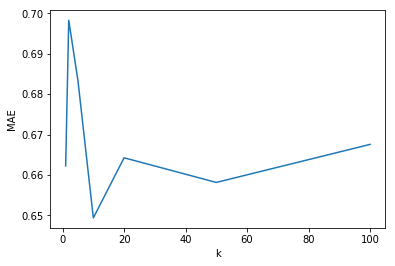

In [10]:
if __name__ == '__main__':
    
    random.seed(42)
    with open('ratingsMatrix_noZeros.pickle', 'rb') as file:
        ratingsMatrix = pickle.load(file)
    ratingsMatrix = np.array(ratingsMatrix, dtype = float)
    ratingsMatrix = ratingsMatrix.T

    originalMatrix = ratingsMatrix.copy()
    trainSet, testSet = train_test_split(originalMatrix, 100)

    for index in testSet:
        ratingsMatrix[index[0]][index[1]] = 0.0

    normalizedRatingsMatrix = normalize_ratings(ratingsMatrix)
    
    kValues = [1, 2, 5, 10, 20, 50, 100]
    maes = []
    rmses = []

    for k in kValues:
        print('k = ', k)
        mae, maeB, rmse, rmseB = evaluate(ratingsMatrix, normalizedRatingsMatrix, testSet, originalMatrix, k)
        print(maeB, rmseB)
        maes.append(maeB)
        rmses.append(rmseB)
        print()
        
    plt.xlabel('k')
    plt.ylabel('MAE')
    plt.plot(kValues, maes)
    plt.savefig('kvalues.png')

In [ ]:
# # textMatrix = np.array([[4,0,0,5,1,0,0],[5,5,4,0,0,0,0],[0,0,0,2,4,5,0],[0,3,0,0,0,0,3]], dtype = float)

# textMatrix = np.array([
# [1,0,2,0,0,1],[0,0,4,2,0,0],
# [3,5,0,4,4,3],[0,4,1,0,3,0],
# [0,0,2,5,4,3],[5,0,0,0,2,0],
# [0,4,3,0,0,0],[0,0,0,4,0,2],
# [5,0,4,0,0,0],[0,2,3,0,0,0],
# [4,1,5,2,2,4],[0,3,0,0,5,0]], dtype = float)
# textMatrix = textMatrix.T

# # print(textMatrix)
# normalized = normalize_ratings(textMatrix)
# print(normalized)

# # print(get_similar_items(normalized, 0, 5))
# print(predict(textMatrix, normalized, 4, 0, True))